# Generate training and test datasets
Split the original ROOT file into two sets: a training set and a sample set. References:
* [Make a simple TTree using PyROOT](https://gist.github.com/raggleton/0686060ed1e94894c9cf)
* [Adding a Branch to Hold a List of Variables](https://root.cern.ch/root/htmldoc/guides/users-guide/Trees.html#adding-a-branch-to-hold-a-list-of-variables)

In [1]:
from utils import split_into_test_and_training

Welcome to JupyROOT 6.23/01


Define the input constants for this section

In [2]:
# The ROOT file to split
source_file = "./data/tau_pipi0_BGx1.root"
# The tree name where the data is stored in the source_file
source_tree_name = "tau"

# The ROOT file to store the results
target_file = "./data/tau_pipi0_BGx1_split.root"

# The variables (a.k.a branches) of the source_tree_name to storein the target_file
variables_to_store = ["tau_0_InvM", "tau_0_matchedMC_InvM"]

Run the script to split the `source_file` into a training set and a test set and store its branches `variables_to_store` in `target_file`

In [4]:
entries = split_into_test_and_training(source_file, target_file, source_tree_name, variables_to_store)
print(f"{entries} events were splitted into {target_file}")

83089 events were splitted into ./data/tau_pipi0_BGx1_split.root


# Generate response matrix from a ROOT ntuple
Define the input file and its metadata

In [1]:
# Select the file and the tree from which to generate the response matrix
response_generator_file = "./data/tau_pipi0_BGx1_split.root"
# Amount of bins
nbins = 50
# Histogram limits
rmin = 0.2
rmax = 1.8

Define the fields to load as the truth and the simulated variables

In [2]:
from utils import compute_response_and_histograms, store_root_objects_in_file

def get_truth(event):
    return event.tau_0_matchedMC_InvM

def get_detected(event):
    return event.tau_0_InvM

# Compute the histograms and the response matrix of the training set
truth_histogram, detected_histogram, response = compute_response_and_histograms(
    response_generator_file, "tau_training",
    get_truth, get_detected,
    histogram_metadata=(nbins, rmin, rmax),
    variable_name="invariant mass"
)

# Store the files in a new root_file
store_root_objects_in_file(
    "./data/response_training_tau_pipi0_BGx1.root",
    truth_histogram, detected_histogram, response
)

# Compute the histograms and the response matrix of the test set
test_truth_histogram, test_detected_histogram, test_response = compute_response_and_histograms(
    response_generator_file, "tau_test",
    get_truth, get_detected,
    histogram_metadata=(nbins, rmin, rmax),
    variable_name="invariant mass"
)

# Store the files in a new root_file
store_root_objects_in_file(
    "./data/response_test_tau_pipi0_BGx1.root",
    test_truth_histogram, test_detected_histogram, test_response
)

print("DONE")

Welcome to JupyROOT 6.23/01
DONE


### Example: loading objects created by `compute_response_and_histograms`
Read the histograms from the ROOT file and plot them

In [5]:
from utils import load_response_and_histograms

# Read the histograms of the given file
histograms_container_path = "./data/response_training_tau_pipi0_BGx1.root"
histograms = load_response_and_histograms(histograms_container_path)

# Turn ROOT objects into python objects
xini, xini_edges = histograms[0]
bini, bini_edges = histograms[1]
Adet, Adet_edges = histograms[2]

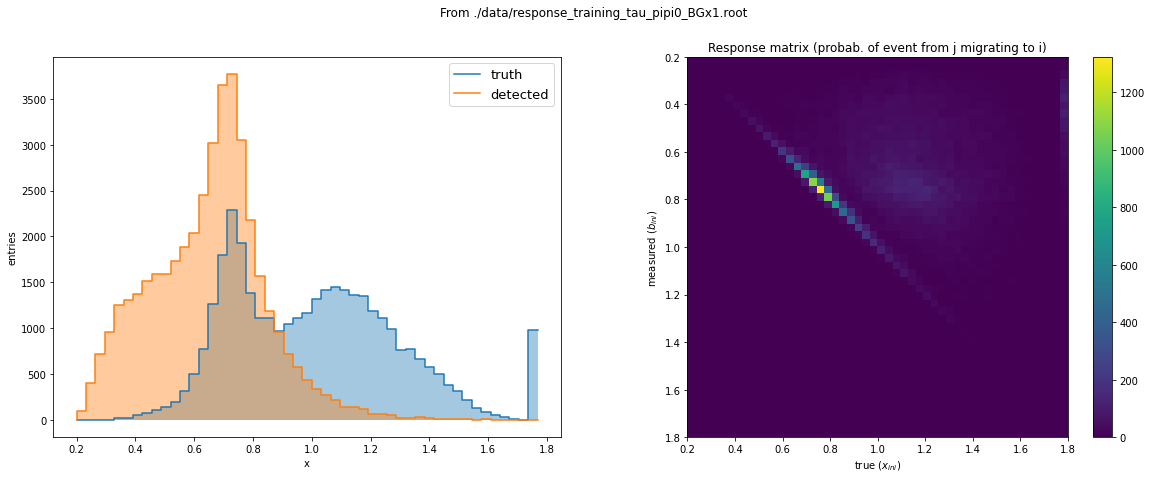

In [6]:
import pylab as plt
%matplotlib inline

axis = xini_edges[0][:-1]

fig, axs = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle(f"From {histograms_container_path}")

"""
Left-hand side
"""
# plot x_ini
axs[0].step(axis, xini, fillstyle="bottom", label="truth")
axs[0].fill_between(axis, xini, step="pre", alpha=0.4)
# plot b_ini
axs[0].step(axis, bini, fillstyle="bottom", label="detected")
axs[0].fill_between(axis, bini, step="pre", alpha=0.4)

axs[0].set_xlabel("x")
axs[0].set_ylabel("entries")
axs[0].legend(prop={'size': 13})

"""
Right-hand side
"""
# Show response matrix
left_edge  = xini_edges[0][0]
right_edge = xini_edges[0][-1]
bottom_edge  = bini_edges[0][-1]
top_edge = bini_edges[0][0]
im = axs[1].imshow(Adet, extent=[left_edge, right_edge, bottom_edge, top_edge])
axs[1].set_xlabel("true ($x_{ini}$)")
axs[1].set_ylabel("measured ($b_{ini}$)")
axs[1].set_title("Response matrix (probab. of event from j migrating to i)")
fig.colorbar(im, ax=axs[1])

# Prepare data for the unfolding

In [7]:
from utils import load_response_and_histograms
from unfolders.utils import root as root_utils
from utils.stats import compute_numpy_covariance_matrix
import numpy as np

# Source file
response_generator_file = "./data/tau_pipi0_BGx1_split.root"
# Histogram's metadata
nbins, rmin, rmax = 50, 0.2, 1.8
variable_title = "invariant mass"

def get_truth(event):
    return event.tau_0_matchedMC_InvM

def get_detected(event):
    return event.tau_0_InvM

# Get the histograms of the training set
truth_histograms = load_response_and_histograms("./data/response_training_tau_pipi0_BGx1.root")
xini, xini_edges = truth_histograms[0]
bini, _ = truth_histograms[1]
R, _ = truth_histograms[2]
R_probabilities = np.true_divide(R, xini, where=xini != 0)

# Get the histograms of the test set
test_histograms = load_response_and_histograms("./data/response_test_tau_pipi0_BGx1.root")
datatrue, _ = test_histograms[0]
data, _ = test_histograms[1]

# Compute the covariance matrix of the test data
statcov = compute_numpy_covariance_matrix(data)

## Annealing unfolding

In [36]:
# Set up logger to print in the notebook
import sys, logging
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.basicConfig(
    stream=sys.stdout,
    format="[%(name)s] %(levelname)s: %(message)s",
    level=logging.INFO,
)
# Unfolding libraries
from unfolders.unfolder import Unfolder
from unfolders.annealing import (
    SimulatedAnnealingBackend,
    SimulatedQuantumAnnealingBackend,
)

# Select the backend
backend = SimulatedAnnealingBackend(4, 100, weight_regularization=0.7)
# Perform unfolding
unfolder = Unfolder(data, statcov, xini, bini, R_probabilities)
result = unfolder.unfold(backend)

num reads: 100


Plot the results

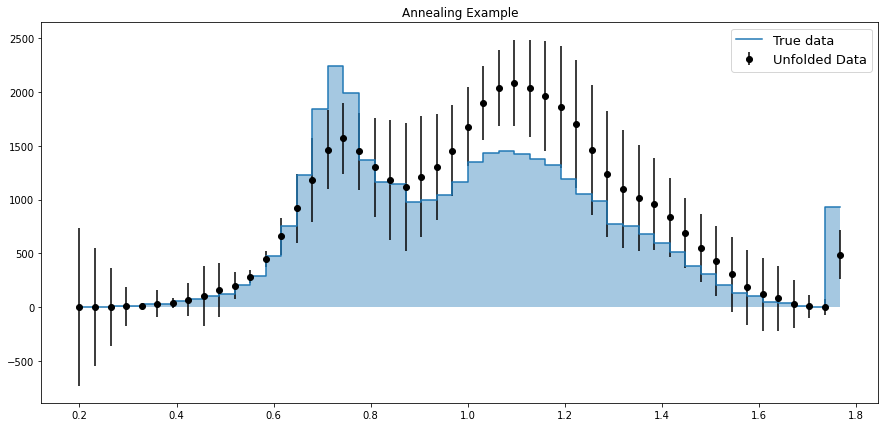

In [37]:
import pylab as plt

# Plot the result
axis = xini_edges[0][:-1]
plt.figure(figsize=(15, 7))
# Plot the original distribution
plt.step(axis, datatrue, fillstyle="bottom", label="True data")
plt.fill_between(axis, datatrue, step="pre", alpha=0.4)
# Plot the unfolded
plt.errorbar(
    axis,
    result.solution,
    yerr=result.error,
    fmt="o",
    color="black",
    label="Unfolded Data",
)
plt.legend(prop={"size": 13})
plt.title("Annealing Example")
plt.show()

## Unfolding with SVD

In [8]:
from unfolders.unfolder import Unfolder
from unfolders.svd import SVDBackend

# Select the backend
backend = SVDBackend(16, rmin, rmax)
# Perform unfolding
unfolder = Unfolder(data, statcov, xini, bini, R_probabilities)
result = unfolder.unfold(backend)

Info in <TSVDUnfold::Unfold>: Unfolding param: 16
Info in <TSVDUnfold::Unfold>: Curvature of weight distribution: 0.451338


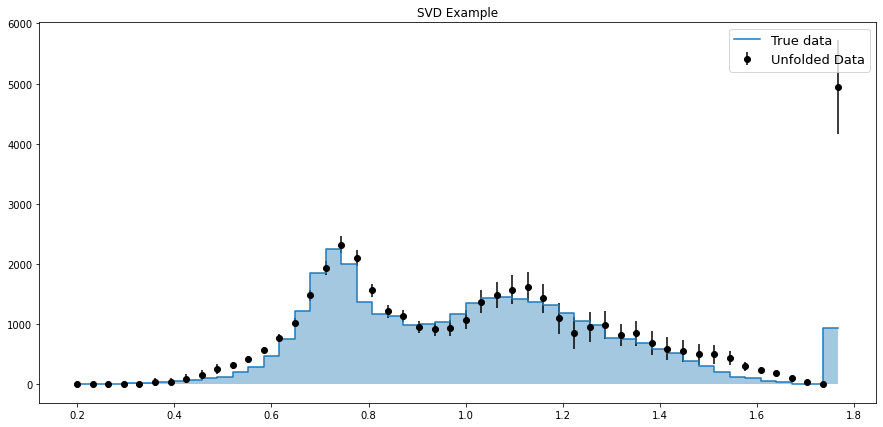

In [9]:
import pylab as plt

# Plot the result
axis = xini_edges[0][:-1]
plt.figure(figsize=(15, 7))
# Plot the original distribution
plt.step(axis, datatrue, fillstyle="bottom", label="True data")
plt.fill_between(axis, datatrue, step="pre", alpha=0.4)
# Plot the unfolded
plt.errorbar(
    axis,
    result.solution,
    yerr=result.error,
    fmt="o",
    color="black",
    label="Unfolded Data",
)
plt.legend(prop={"size": 13})
plt.title("SVD Example")
plt.show()

(0.001, 10.0)

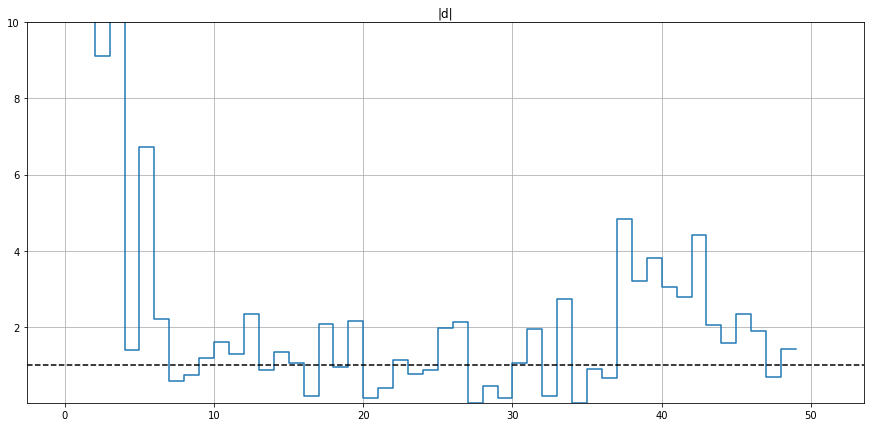

In [10]:
kreg_distribution = backend.kreg_distribution
plt.figure(figsize=(15, 7))
plt.step(range(0,nbins), kreg_distribution)
plt.axline((0,1), (nbins+1,1), color="black", linestyle="--")
plt.title("|d|")
plt.grid()
plt.ylim(0.001, 10)